## Project: **Finding Lane Lines on the Road** 
***
**Finding Lane Lines on the Road**

Lane line detection is a crucial feature of Self-Driving Vehicles. It's an extremely important step for detection of steering angles and localization on the road. The main goal of this project is to develop a pipeline for identification of lane lines on the Road using a series of images and video streams.

------------------------------------------

## Importing useful Packages

In [126]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pylab import *
import math
import os
%matplotlib inline

## Lane Detection Pipeline

## Helper Functions

## Grayscale Image function

This function converts an image with multiple channels (colors) to a single channel (intensity data). Therefore, the processing is faster and it's an essential step before the detection of lane edges.

In [127]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Gaussian blur function

This function filters the noise, provides smoothness and prevents false edge detection.

In [128]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Canny edge detection function

Gaussian filters are used to smooth the image and reduce the noise. This function estimates the gradients of the image and supresses the image to determine potential edges based on the thresholds. The last operation is called tracking edge by hysteresis where the function suppresses those edges that are weak and non-connected to strong ones.

In [129]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

## Region of interest (ROI)

This function (ROI) is responsible for filtering regions of interest based previously estimated edges and vertices. In our case, the vertice avoids regions without roads.

In [130]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Defining a blank mask to start with:
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Hough transformation
The Hough transform to find lines in an image.

In [131]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines) # draw new lines using linear regression 
    return line_img

## Weighted image
Mixing the lines from hough transformation with the original image. The resulting image is based
on the following equation: initial_img * α + img * β + γ

In [132]:
def weighted_img(img, initial_img, α=0.7, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Return Arrays without Inf and NaN
This functions imports an array and returns it without + or -inf and NaN values.

In [133]:
def check_inf_nan(check):
    check = np.array(check) # transform into array
    check = check[~np.isinf(check)]
    check = check[~np.isnan(check)]
    return check

## Find Average
Take the average of the slope and intersection arrays. Filter points with slopes for which value-slope_avg < error_factor*standard deviation.

In [134]:
def find_average_fit(inter_slope):
    
    counter = 0
    new_slope = []
    new_inter = []
    error_factor = 1.2
    
    if len(inter_slope)==1: # If the slope array has only one element [x1,y1,x2,y2]
        return inter_slope[0][0],inter_slope[0][1]

    # Separate slope and intersection to take the averages
    slope = [x[0] for x in inter_slope] 
    inter = [x[1] for x in inter_slope]
    
    # Check for Inf and NaN variables
    slope = check_inf_nan(slope)
    inter = check_inf_nan(inter)
    
    slope_std = np.std(slope) # Estimate the standard deviation
    slope_avg = np.mean(slope)
    inter_avg = np.mean(inter)
    
    # Dealing with the cases where [x1,y1,x2,y2]~[x'1,y'1,x'2,y'2]
    if slope_std == 0:
        return slope_avg,inter_avg
    
    # Filter points with slopes for which the error < error_*standard deviation of the slope
    for value in slope:
        if(value-slope_avg < error_factor*slope_std):
            new_slope.append(value)
            new_inter.append(inter[counter])
        counter+=1    
    
    new_slope_avg = np.mean(new_slope)
    new_inter_avg = np.mean(new_inter)
    return new_slope_avg,new_inter_avg

## Calculate the x coordinate of the intersection
This function returns the x coordinate of the intersection between the positive and negative lines. Given y1=ax+b, y2=cx+d and y1=y2: x_intersection = (d-b)/(a-c)

In [135]:
def x_intersection(pos_slope,pos_inter,neg_slope,neg_inter):
    return (neg_inter-pos_inter)/(pos_slope-neg_slope)

## Find points with positive and negative slopes
After determining the negative and positive slopes, this function draw the lines based on the points. The scale factor is an important feature because it shrinks the line from the intersection point. I chose scale=0.9, however, scale=0.5 would give the center of the righ and left lines.

In [136]:
def draw_line_from_regression(coeff_pos, inter_pos, coeff_neg, inter_neg, inter_x_coord, img, imshape=[540,960],color=[255, 0, 0,.7], thickness=7):
    
    # Scale defines the percentage of the regression line from the top inter_x_coord
    scale = .9
    scale_pos = 1./scale
    count = 0
        
    if coeff_neg < 0:
        
        p_2_x = int(0)
        p_2_y = int(inter_neg)
        p_1_x = int(inter_x_coord*scale)
        p_1_y = int((coeff_neg*inter_x_coord*scale) + inter_neg)
        p_2 = (p_2_x, p_2_y)
        p_1 = (p_1_x, p_1_y)
        
    if coeff_pos > 0:
        
        p_4_x = int(imshape[1])
        p_4_y = int((coeff_pos* imshape[1]) + inter_pos)
        p_3_x = int(inter_x_coord*scale_pos)
        p_3_y = int((coeff_pos*inter_x_coord*scale_pos) + inter_pos)
        p_4 = (p_4_x, p_4_y)
        p_3 = (p_3_x, p_3_y)
    
    cv2.line(img, p_1, p_2, color, thickness) # Line with negative slope coefficient
    cv2.line(img, p_3, p_4, color, thickness) # Line with positive slope coefficient

## add_slope()
This function appends slope and intersection coefficients under conditions fixed in the main pipeline.

In [137]:
def add_slope(previous_slope,previous_inter,slope_value,x1,y1,x2,y2):
    add_slope = []
    add_inter = []
    add_slope = previous_slope.copy()
    add_inter = previous_inter.copy()
    add_slope.append([x1, y1])
    add_slope.append([x2, y2])
    add_inter.append([slope_value, y1-slope_value*x1])
    return add_slope,add_inter

## Case of empty arrays in the main Pipeline
This function is called if the arrays are empty for slope > 0 or slope < 0. This function is called if line_length < 60 (Check main pipeline)

In [160]:
def empty_slope(lines,value):
    
    pos_slope = []
    neg_slope = []
    pos_inter = []
    neg_inter = []
   
    if(value=='positive_slope'):
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    pos_slope,pos_inter = add_slope(pos_slope,pos_inter,slope,x1,y1,x2,y2) 
        return pos_slope,pos_inter
    
    elif(value=='negative_slope'):
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope < 0:
                    neg_slope, neg_inter = add_slope(neg_slope,neg_inter,slope,x1,y1,x2,y2)
        return neg_slope,neg_inter            

In [146]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape=[540,960]
    pos_slope = []
    neg_slope = []
    pos_inter = []
    neg_inter = []
    max_len = 60 # maximum length of the line
    
    # We can separate right(negative) and left(positive) lines by checking the slope, length and y intersection.
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2-x1==0):
                break
            slope = (y2-y1)/(x2-x1)
            line_length= np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    # If slope is not empty, append slope and intersection to arrays in case slope >0 or slope <0
            
            if ~math.isnan(slope):
                if line_length > max_len:
                    if slope > 0:
                        pos_slope,pos_inter = add_slope(pos_slope,pos_inter,slope,x1,y1,x2,y2) 
                    elif slope < 0:
                         neg_slope, neg_inter = add_slope(neg_slope,neg_inter,slope,x1,y1,x2,y2)
              
    # If pos_slope or neg_slope is empty
    if not pos_slope:
        pos_slope,pos_inter = empty_slope(lines,value='positive_slope')
        
    if not neg_slope:
        neg_slope,neg_inter = empty_slope(lines,value='negative_slope')
                
    # List to Array
    pos_slope,neg_slope = np.array(pos_slope),np.array(neg_slope)

    # Extract an average coefficient
    coef_pos_slope, coef_pos_inter = find_average_fit(pos_inter)
    coef_neg_slope, coef_neg_inter = find_average_fit(neg_inter)
    
    # Calculate x coordinate from the intersection between positive and negative lines
    x_inter_coord = x_intersection(coef_pos_slope,coef_pos_inter,coef_neg_slope,coef_neg_inter)
    
    # Draw the both regression lines in the image
    draw_line_from_regression(coef_pos_slope, coef_pos_inter, coef_neg_slope, coef_neg_inter, x_inter_coord, img)

## Plot Polygon from Vertices
This function is responsible for plotting the polygon that defined by the vertices in the main pipeline. These vertices filters the region of interest (ROI).

In [147]:
def plot_polygon(vertices,img):
    pts = vertices.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=10)
    cv2.fillPoly(img, [pts], color=(145, 0, 255,255))
    plt.imshow(img)

## Plot Image Processing
Plot of the image processing: Grayscale, Potential Edges from Canny Transform, Polygons for ROI, Image Mask, Hough Transform and final result. This function also saves the images with the previous transformations.

In [159]:
def plot_images(file,gray,edges,vertices,img2,target,lines,result):
        a=3
        b=2
        scale=13
        fig = plt.figure(figsize=(scale,scale))
        subplot(a,b,1)
        plt.imshow(gray,cmap='gray')
        title('Grayscale test_images/'+file)
        subplot(a,b,2)
        plt.imshow(edges,cmap='gray')
        title('Edges - Canny test_images/'+file)
        subplot(a,b,3)
        plot_polygon(vertices,img2)
        title('Polygon from Vertices test_images/'+file)
        subplot(a,b,4)
        plt.imshow(target,cmap='gray')
        title('Image Mask test_images/'+file)
        subplot(a,b,5)
        plt.imshow(lines)
        title('Hough transform test_images/'+file)
        subplot(a,b,6)
        plt.imshow(result, cmap = "gray")
        title('Result test_images/'+file)
    
        fig.savefig('output_pipeline_'+file+'.eps',dpi=100)

## Test Images

### Results

In [157]:
files = os.listdir("test_images/")
if '.DS_Store' in files:
    files.remove('.DS_Store')

### Lane detection Pipeline
The main pipeline open the images and apply all the tranformations. It saves the files in the test_images folder with the prefix 'output_'+filename.

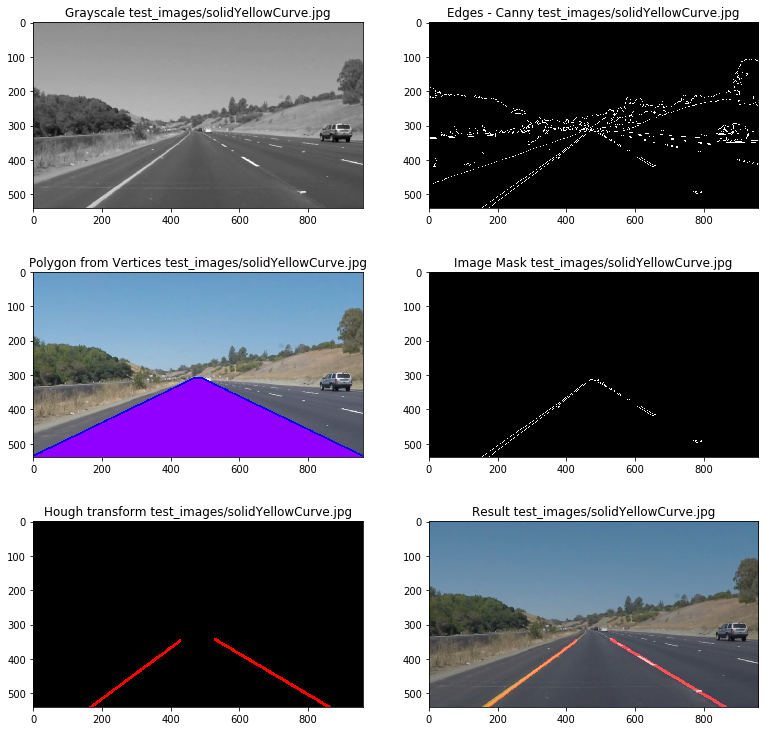

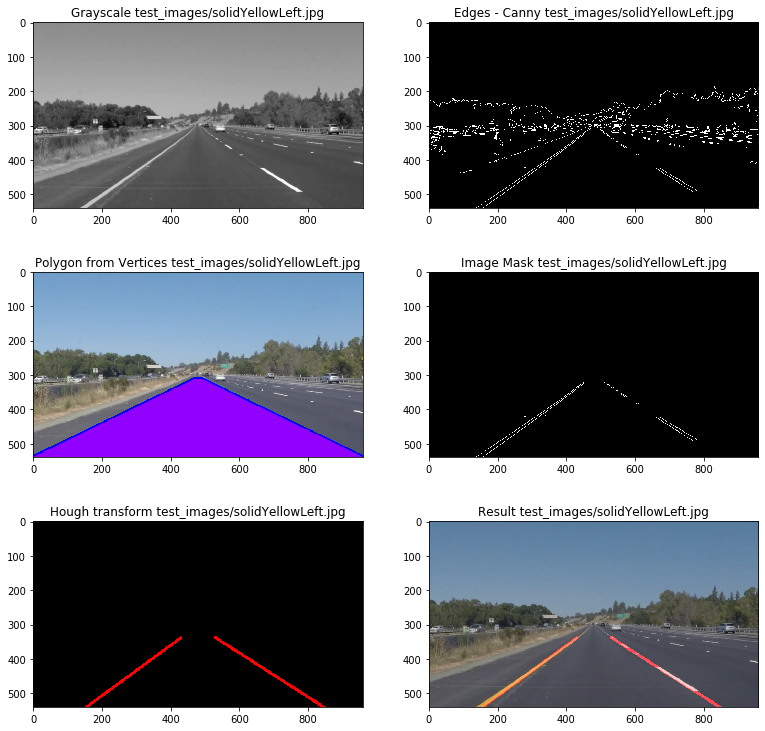

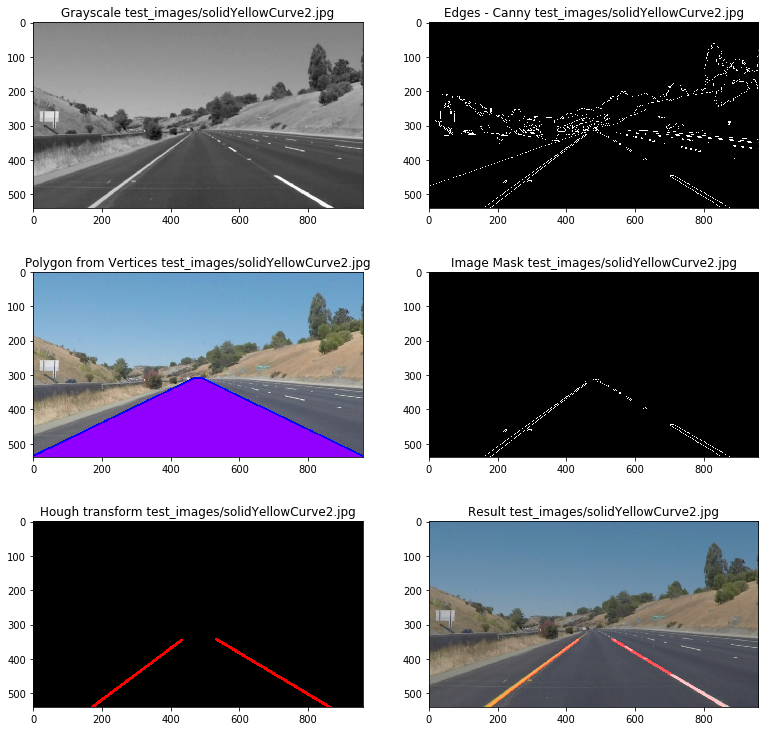

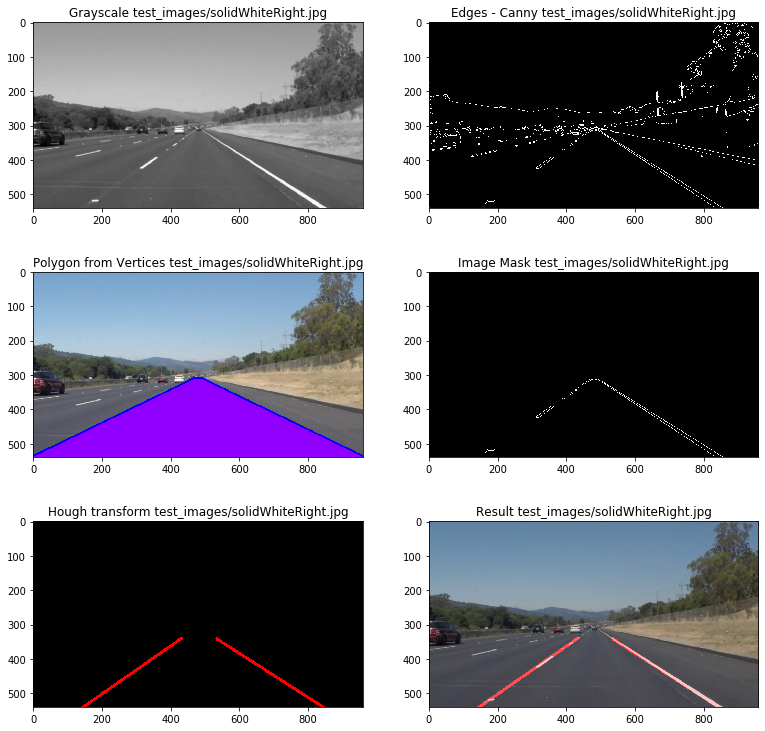

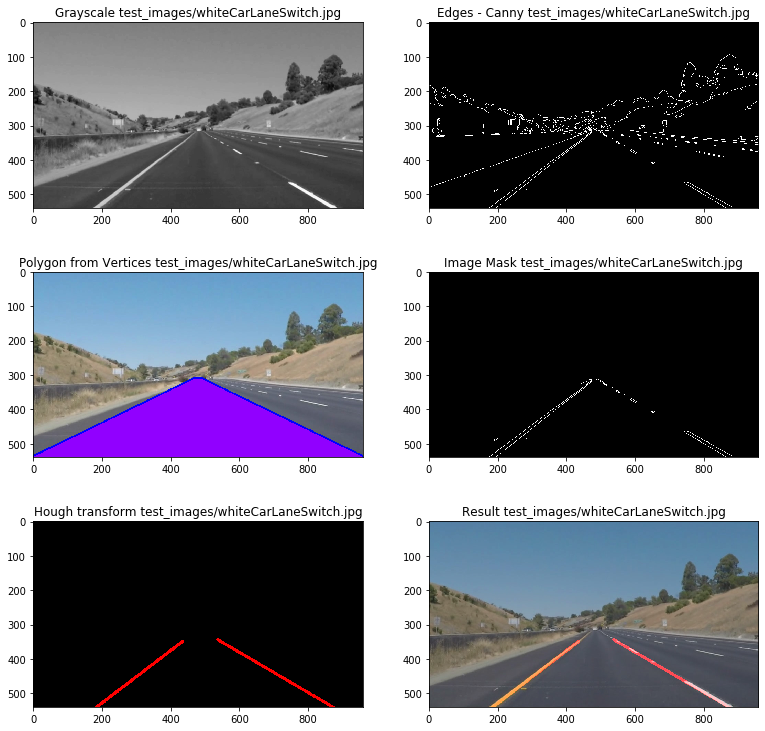

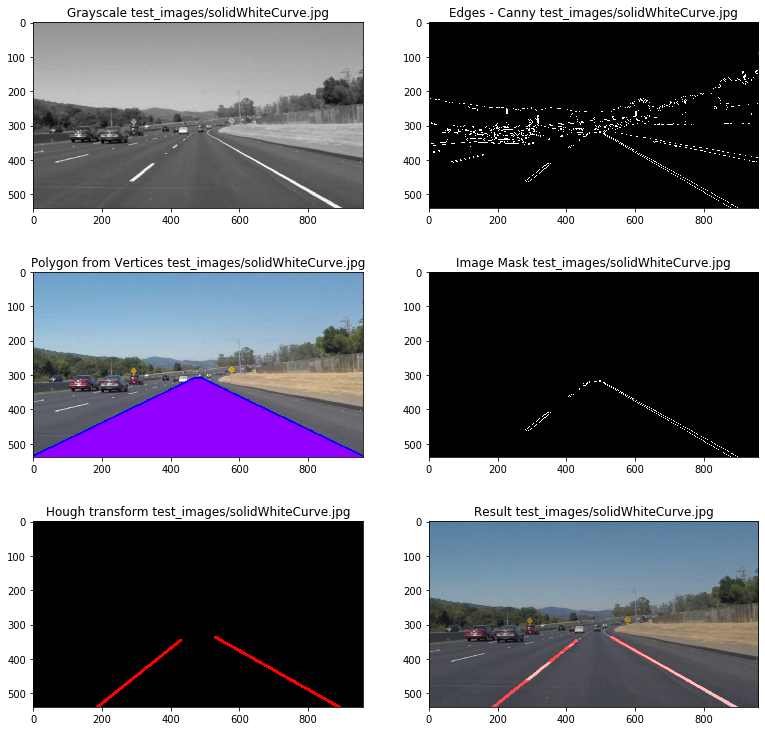

In [158]:
for file in files:
    if file[0:6] != "output":
    
        img = mpimg.imread("test_images/"+file)
        img2 = mpimg.imread("test_images/"+file)
        
        gray = grayscale(img)
        
        gray = gaussian_blur(gray,3)
       
        # Subplot of Canny transform canny(image,low_threshold,high_threshold)
        
        edges = canny(gray,50,150)     
        
        imshape = img.shape
        vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
        
        # Applies an image mask. Only keeps the region of the image defined by the polygon
        # formed from `vertices. The rest of the image is set to black.
        target = region_of_interest(edges, vertices)
        
        lines = hough_lines(target,1,np.pi/180,35,5,2) # regression included on draw_lines function
    
        # result = image * α + lines * β + γ, coefficients are used to help tune the lines.
        
        result = weighted_img(lines,img,α=0.8, β=1.) 
        
        plot_images(file,gray,edges,vertices,img2,target,lines,result)
        
        # Transform to RGB
        r, g, b = cv2.split(result)
        result = cv2.merge((b,g,r))
        cv2.imwrite("test_images/output_"+file,result)


## Test on Videos

In [162]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Process the First Video Stream
Returns the final output (image where lines are drawn on lanes)

In [163]:
def process_image(image):   
    
    # np.pi/180 = # angular resolution (rad) for the Hough grid
    # Threshold = 35 , intersections in Hough grid cell 
    # min_line_len = 5 , min number (px) for a line
    # max_line_gap = 2, # max gap (px) between line segments
    
    gray = grayscale(image) # GrayScale image 
    gray = gaussian_blur(gray,3) # Gaussian Blur
    edges = canny(gray,50,150)   # Canny edge detection
        
    ### Hogher Transform
    imshape = img.shape 
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices) # Mask edges
        
    lines = hough_lines(target,1,np.pi/180,35,5,2)  # Hough to RGB for weighted
    result = weighted_img(lines,image,α=0.8, β=1.0) # result = image * α + lines * β + γ
    
    return result

In [164]:
white_output = './test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|▏         | 5/221 [00:00<00:04, 47.14it/s, now=None]

Moviepy - Building video ./test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video ./test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready ./test_videos_output/solidWhiteRight.mp4
CPU times: user 2.91 s, sys: 375 ms, total: 3.29 s
Wall time: 8.16 s


Play the video inline or find the video in your filesystem.

In [165]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Process the First Video Stream
This video has a solid yellow lane on the left. The same Pipeline works very well.

In [166]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5) # play only from 0 to 5 seconds of the video
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 8/681 [00:00<00:09, 72.86it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 9.32 s, sys: 950 ms, total: 10.3 s
Wall time: 23.2 s


In [167]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [168]:
def new_process_image(image):   
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # np.pi/180 = # angular resolution (rad) for the Hough grid
    # Threshold = 35 , intersections in Hough grid cell 
    # min_line_len = 5 , min number (px) for a line
    # max_line_gap = 2, # max gap (px) between line segments
    
    gray = grayscale(image) # GrayScale image 
    gray = gaussian_blur(gray,3) # Gaussian Blur
    edges = canny(gray,50,150)   # Canny edge detection
        
    ### Hogher Transform
    imshape = img.shape 
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices) # Mask edges
        
    lines = hough_lines(target,1,np.pi/180,35,5,2)  # Hough to RGB for weighted
    result = weighted_img(lines,image,α=0.8, β=1.0) # result = image * α + lines * β + γ
    
    return result

In [169]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,10)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/250 [00:00<00:06, 39.94it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 9.32 s, sys: 976 ms, total: 10.3 s
Wall time: 22.5 s


In [170]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Challenges

1. The first challenge was to tune the parameters for the hough transformation. 
2. I had some issues with NaNs and Inf while debbuging the main pipeline.
3. The most demanding was to stabilize the lane lines of both video streams.


## Identify potential shortcomings

1. The lane lines are straight and very stable in both video streams, however, the pipeline does not work with the challenging video. I believe that it would be also very difficult to detect the lane lines in medium to extreme environments conditions including shades, reflections, occlusions and diverse weather constraints.


## Possible improvements to your pipeline

1. Find a robust and stable curvature for the lane detection instead of a straigth of line. 
2. Tune the mask color parameters and split white and yellow lane lines for processing the challenging video.